In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("tripadvisor_european_restaurants.csv")
pd.set_option('display.max_columns',50)

In [186]:
#df.head()
len(df[df["price_range"].notna()].index)

304327

In [187]:
print("Number of rows    :",len(df.index))
print("Number of columns :",len(df.columns))

Number of rows    : 1083397
Number of columns : 42


DESCRIPTION OF MISSING VALUES

keywords                             90.843800
atmosphere                           75.836651
awards                               75.712227
price_range                          71.909928
features                             70.702614
special_diets                        68.593600
working_shifts_per_week              45.187960
open_hours_per_week                  45.187960
open_days_per_week                   45.187960
original_open_hours                  45.187960
food                                 44.680943
value                                44.370162
service                              44.222940
meals                                41.356031
city                                 36.984134
province                             31.441106
price_level                          25.586650
cuisines                             15.608590
top_tags                             10.211769
popularity_generic                    9.026423
avg_rating                            8.919722
excellent    

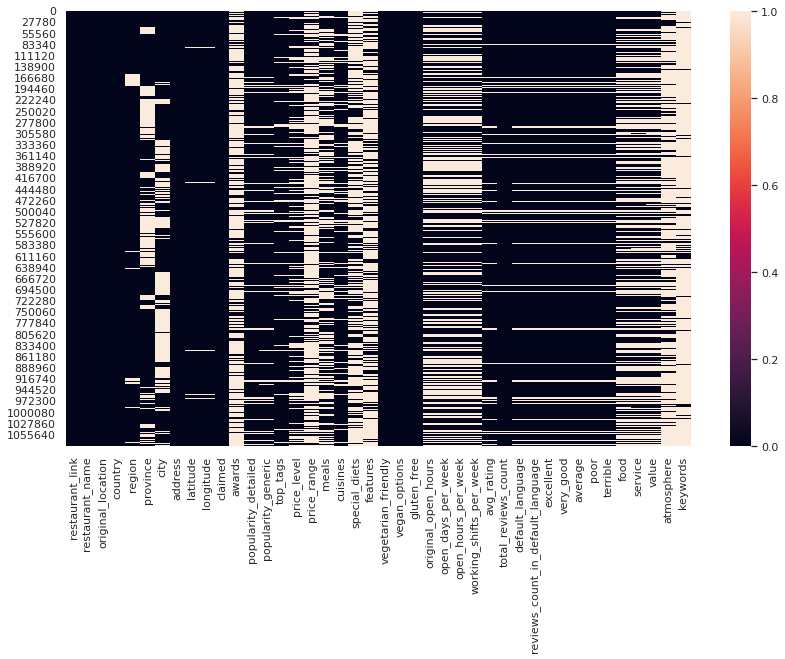

In [216]:
#print("MISSING VALUES\n")

missing_values=df.isnull().sum().sort_values(ascending=False)
total_missing_values = missing_values.sum()
missing_values = missing_values.astype(float)
for val in missing_values.index:
	missing_values[val] = (missing_values[val]/len(df.index)) * 100

print(missing_values)

total_no_of_cells=int(np.product(df.shape))

print("\nTotal_no_of_missing_cells : ",total_missing_values)
print("\nTotal_no_of_cells : ",total_no_of_cells)
print("\nPercentage_error : ",(total_missing_values/total_no_of_cells)*100)

%matplotlib inline
plt.figure(figsize=(14,8))
sns.heatmap(df.isna())
plt.show()


DEALING WITH MISSING VALUES

In [189]:
#keywords has a ~91% missing value rate
#reviews_count_in_default_language is redundant => sum(excellent, very_good, average, poor, terrible) => use to check for outliers and then drop
#atmosphere is useless for now ~75% missing 
#price_range has quite a few inconsistent values (CH\xa) and ~72% missing values
#awards, features, all seem like useful information if present (for some sort of analysis)
#default_language, reviews_count_in_default_language, excellent,very_good, average, poor, terrible all are related. i.e. group and split them for analysis
#special_diets => split into vegetarian_friendly, vegan options, gluten_free for easy reference

df1 = df.drop(columns=["atmosphere","keywords","price_range"], axis = 1)

#latitude/longitude is required to map it onto a map
#avg_rating is NaN with other columns having meaningful(?) data only in 235 rows (~0.02%)
df2 = df1.dropna(subset=['latitude','longitude','avg_rating']).copy()

missing_values=df1.isnull().sum().sort_values(ascending=False)
total_missing_values = missing_values.sum()
missing_values = missing_values.astype(float)
for val in missing_values.index:
	missing_values[val] = (missing_values[val]/len(df2.index)) * 100

print(missing_values)
print("\nPercentage_error : ",(total_missing_values/int(np.product(df2.shape)))*100)

awards                               84.176434
features                             78.606774
special_diets                        76.261984
working_shifts_per_week              50.239723
open_hours_per_week                  50.239723
open_days_per_week                   50.239723
original_open_hours                  50.239723
food                                 49.676025
value                                49.330500
service                              49.166819
meals                                45.979406
city                                 41.118755
province                             34.956047
price_level                          28.447096
cuisines                             17.353544
top_tags                             11.353388
popularity_generic                   10.035527
avg_rating                            9.916897
poor                                  9.768815
average                               9.768815
very_good                             9.768815
excellent    

DATA VISUALISATION

There are 974,458 unique restaurants in the dataframe
There are 24 unique countries in the dataframe


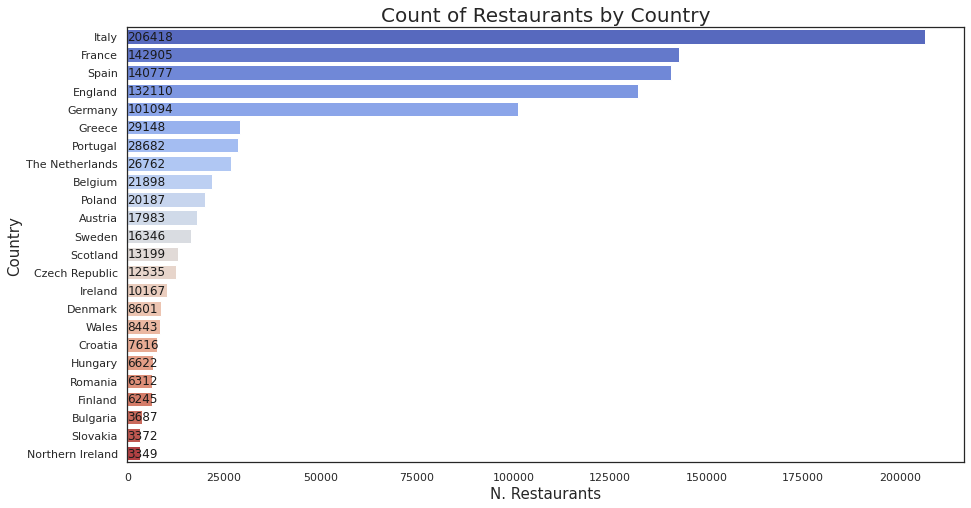

In [190]:
#Nishanth
# converting the price values '€', '€€-€€€', and '€€€€' into three categories (low, medium, high)
df2.loc[:, 'price_level_cat'] = ['low' if x == '€' else 'medium' if x == '€€-€€€' else 'high' if x == '€€€€' else np.nan for x in df2['price_level']]
# taking only the first type of cuisine in the records that includes multiple cuisine values
df2.loc[:, 'first_cuisine'] = [x.split(',', 1)[0] if ',' in x else np.nan if x == 'nan' else x for x in df2['cuisines'].astype('str')]

print(f'There are { df2.restaurant_link.nunique():,} unique restaurants in the dataframe')
print(f'There are { df2.country.nunique()} unique countries in the dataframe')

# Count of restaurant countries
sns.set(style='white')

countries_count = df2.country.value_counts()

plt.figure(figsize=(15, 8))
plt.title('Count of Restaurants by Country', size=20)
ax = sns.barplot(x=countries_count.values, y=countries_count.index, palette='coolwarm')
plt.xlabel('N. Restaurants', size=15)
plt.ylabel('Country', size=15)
for i, v in enumerate(countries_count.values):
    plt.text(x=40, y=i+0.2, s=v, color='k', fontsize=12)
plt.show()

In [191]:
#Sujith
import plotly.express as px
df3 = df2.groupby(['country','city']).agg(
    restaurant_total = pd.NamedAgg(column='restaurant_link', aggfunc=np.size),
    mean_rating = pd.NamedAgg(column='avg_rating',aggfunc=np.mean),
    latitude = pd.NamedAgg(column='latitude',aggfunc=np.mean),
    longitude = pd.NamedAgg(column='longitude',aggfunc=np.mean)
).reset_index().sort_values(by='restaurant_total', ascending = False).head(20)
#display(df3)
fig = px.scatter_geo(data_frame=df3, lat='latitude', lon='longitude', color='mean_rating', hover_name='city',
                     scope='europe', size='restaurant_total', size_max=40, projection='natural earth', labels={'mean_rating': 'Mean Rating'})
fig.update_layout(title='European map of the 20 most popular cities (size by total restaurants)', title_x=0.5,
                  width=800, height=500, margin={'r':0, 'l':0, 'b':0, 'pad':0})
fig.show()

In [192]:
#Most popular cuisines

df2 = df[df['cuisines'].notna()]
d = dict()
for cuisine in df2['cuisines']:
	for val in cuisine.split(','):
		if val.strip() in d.keys():
			d[val.strip()] += 1
		else:
			d[val.strip()] = 1
print([val for val in sorted(zip(d.values(),d.keys()),reverse=True)[0:5]])

[(235823, 'Italian'), (208436, 'European'), (173020, 'Mediterranean'), (114070, 'Pizza'), (109188, 'Cafe')]


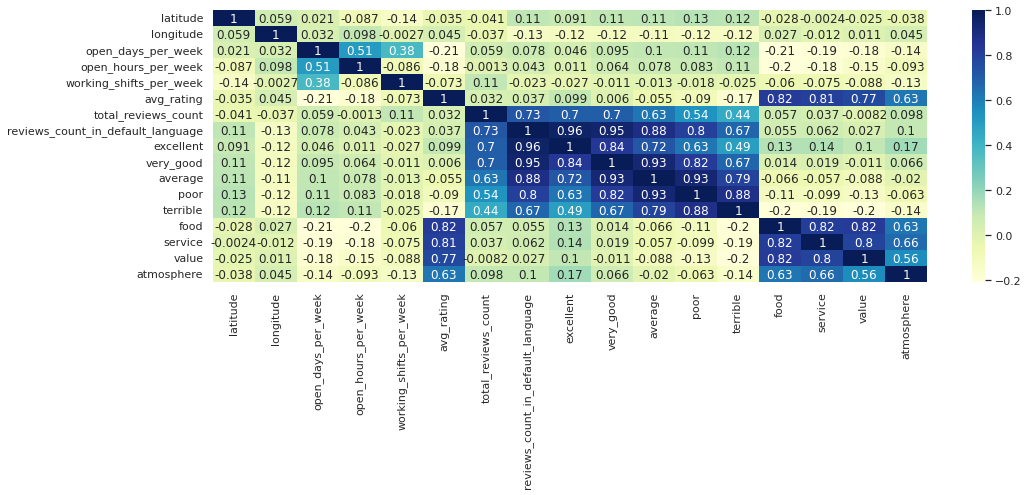

In [194]:
#correlation analysis

plt.figure(figsize = (16,5))
import seaborn as sb
dataplot = sb.heatmap(df2.corr(), cmap="YlGnBu", annot=True)
plt.show()
#df2.head()
 

EDA INFERENCE 

Missing values have either been imputed or dropped in the columns relevant to our interest.

Some columns are left untouched even with null values as they are used later on for model building (The null values are changed there as required.)

Exploratory analysis helps us visualize country-wise restaurant distribution. Italy seems to have the highest numebr of restaurants and the most popular cuisine seems to be Italian. Athens seems to be an outlier given both its geographical location as well as the abnormally high mean rating. Most of the popular cities with respect to the restaurants seem to be distributed towards the west of Europe. A few of the columns such as food, service, value and atmosphere seem to be highly correlated indicating that they have quite a strong relationship. 

Two kinds of models have been built : 

Two regression models in order to predict rating of a restaurant given the food, service and value 

Two recommendation systems in order to recommend restaurants to users given their location (latitude and longitude) and preferences (key words)

END OF EDA... START OF MODEL BUILDING (STARTING WITH LINEAR REGRESSION)

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [195]:
df1 = df2[["restaurant_name","original_location","country","region","province","city","address","latitude","longitude","cuisines","top_tags","gluten_free","vegan_options","vegetarian_friendly","food","service","value","atmosphere","avg_rating"]]
df1.head()

,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,cuisines,top_tags,gluten_free,vegan_options,vegetarian_friendly,food,service,value,atmosphere,avg_rating
0,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,French,"Cheap Eats, French",N,N,N,4.0,4.5,4.0,NaN,4.0
2,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,"French, European","Cheap Eats, French, European",N,N,N,NaN,NaN,NaN,NaN,5.0
3,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,French,"Cheap Eats, French",N,N,N,4.5,4.5,4.5,NaN,4.0
4,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Occitanie,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,French,"Mid-range, French",N,N,N,4.5,4.5,4.5,NaN,4.5
5,L'Auberge Du Vieux Crozet,"[""Europe"", ""France"", ""Auvergne-Rhone-Alpes"", ""...",France,Auvergne-Rhone-Alpes,Loire,Le Crozet,59 place du Puits ancienne adresse le Bourg re...,46.169823,3.855819,French,"Mid-range, French",N,N,N,4.5,4.5,4.5,NaN,4.5


In [196]:
#df1 => Dataframe with relevant columns only taken from df2 
#df2 => Dataframe after preprocessing

df1.dropna(axis=0,how='any',thresh=None,subset=None,inplace=True)
mv=df1["service"].isnull().sum()
print(mv)
df3 = df1.copy()
df1 = df1[["food","service","value","atmosphere","avg_rating"]]
df1

0


,food,service,value,atmosphere,avg_rating
9,4.5,4.5,4.5,4.5,4.5
17,4.5,4.5,4.5,4.0,4.5
20,4.5,4.5,4.0,4.0,4.5
21,4.0,4.0,4.0,4.0,4.0
24,4.0,4.0,3.5,3.5,3.5
...,...,...,...,...,...
1083063,4.0,3.5,3.5,4.5,3.5
1083065,4.5,4.5,4.0,4.5,4.5
1083204,4.0,3.5,4.0,3.0,3.5
1083251,4.0,4.0,3.5,4.0,3.5


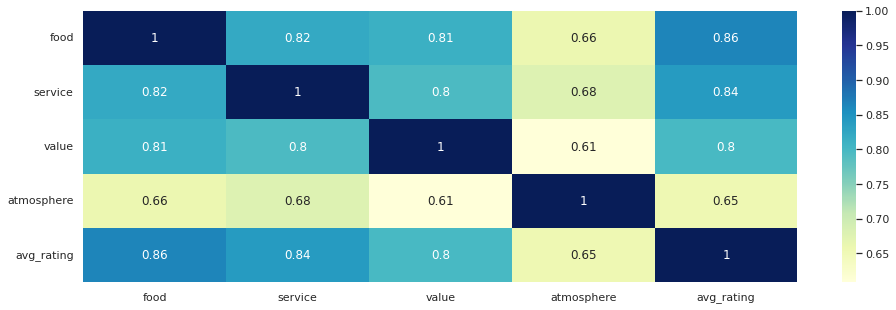

In [197]:
#correlation in df1
plt.figure(figsize = (16,5))
import seaborn as sb
dataplot = sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [198]:
df1.describe()

,food,service,value,atmosphere,avg_rating
count,82511.000000,82511.000000,82511.000000,82511.000000,82511.000000
mean,4.109755,4.093727,3.978748,3.964053,4.040807
std,0.489881,0.490275,0.500200,0.552008,0.502287
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,3.500000,3.500000,4.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000
75%,4.500000,4.500000,4.500000,4.500000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [199]:
from sklearn.model_selection import train_test_split
X = df1.drop(["avg_rating"], axis=1)
y = df1["avg_rating"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.30)

In [200]:
#linearRegression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model_fit=model.fit(Xtrain, ytrain )
preds1 = model_fit.predict(Xtest)
from sklearn.metrics import mean_squared_error
import numpy as np
rms1 = np.sqrt(mean_squared_error(ytest,preds1))
print(rms1)

0.22229605817534132


In [201]:
#ridgeRegression
from sklearn.linear_model import Ridge
model = Ridge(alpha=1)
model_fit2=model.fit(Xtrain, ytrain )
preds2 = model_fit2.predict(Xtest)
from sklearn.metrics import mean_squared_error
import numpy as np
rms2 = np.sqrt(mean_squared_error(ytest,preds2))
rms2

0.22229595312694622

RECOMMENDATION SYSTEM USING A HARD-CODED DECISION TREE - INITIAL APPROACH

In [202]:
#decision-tree recommendor function
from math import dist
def recommend(user,df,head):
	df4=df[df["country"]==user["country"]]
	if user["vegan"] in ["Y","N"]:
		df4=df4[df4["vegan_options"]==user["vegan"]]
	if user["vegetarian"] in ["Y","N"]:
		df4=df4[df4["vegetarian_friendly"]==user["vegetarian"]]
	if user["gluten-free"] in ["Y","N"]:
		df4=df4[df4["gluten_free"]==user["gluten-free"]]
	d = []
	for i in df4.index:
		d.append(dist([df4["latitude"][i],df4["longitude"][i]],[user["latitude"],user["longitude"]]))
	df4["dist"] = d
	df4.sort_values(by=["dist","avg_rating"],inplace=True)
	df4 = df4.drop(["dist"], axis=1)
	return df4.head(head)

In [203]:
#user samples
user1 = {"name":"Nishanth S", 
		"latitude":46.338924, 
		"longitude":2.238150,
		"country":"Italy",
		"vegetarian": "N",
		"vegan":"N",
		"gluten-free":"N",
		}

user2 = {"name":"Rohith G", 
		"latitude":50.438175, 
		"longitude":6.864503,
		"country":"France",
		"vegetarian": "Y",
		"vegan":"any",
		"gluten-free":"Y",
		}

user3 = {"name":"P P Sujith", 
		"latitude":43.246823, 
		"longitude":-1.918702,
		"country":"Germany",
		"vegetarian": "N",
		"vegan":"N",
		"gluten-free":"N",
		}

In [204]:
recommend(user1,df2,5)

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,claimed,awards,popularity_detailed,popularity_generic,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,original_open_hours,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,default_language,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
867305,g7648033-d12663303,Gourmandyne par Benoit Molin,"[""Europe"", ""Italy"", ""Trentino-Alto Adige"", ""Pr...",Italy,Trentino-Alto Adige,Province of South Tyrol,NaN,"991 Avenue Des Vergers, 13750 Plan Italy",43.824356,5.019394,Unclaimed,NaN,NaN,NaN,"Bakeries, French, Cafe, Fast food",NaN,NaN,NaN,"French, Cafe, Fast food, European, Fusion",NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
774658,g194684-d15318485,Ristorante Montano Pian del Colle,"[""Europe"", ""Italy"", ""Piedmont"", ""Province of T...",Italy,Piedmont,Province of Turin,NaN,"Localita Pian del Colle Melezet, 10052, Bardon...",45.049694,6.666278,Claimed,NaN,#42 of 49 Restaurants in Bardonecchia,#51 of 60 places to eat in Bardonecchia,"Mid-range, Italian, Bar, Cafe",€€-€€€,€10-€30,"Breakfast, Lunch, Dinner","Italian, Cafe, Bar, Pub",NaN,NaN,N,N,N,"{""Mon"": [""10:00-17:00""], ""Tue"": [""10:00-17:00""...",7.0,62.0,8.0,3.5,21.0,English,1.0,0.0,0.0,1.0,0.0,0.0,4.0,3.5,4.0,NaN,NaN
774661,g194684-d18856708,La Crota dello Chef,"[""Europe"", ""Italy"", ""Piedmont"", ""Province of T...",Italy,Piedmont,Province of Turin,NaN,"Via Giorgio Des Geneys, 20 B, 10052, Bardonecc...",45.079880,6.696270,Claimed,NaN,#43 of 49 Restaurants in Bardonecchia,#52 of 60 places to eat in Bardonecchia,"Mid-range, Italian, Brew Pub, Pub",€€-€€€,€8-€24,"Breakfast, Dinner, Drinks","Italian, Brew Pub, Pub, Soups, Northern-Italia...",NaN,NaN,N,N,N,"{""Mon"": [""09:00-22:30""], ""Tue"": [""12:00-14:30""...",6.0,43.5,11.0,3.0,23.0,All languages,23.0,8.0,4.0,1.0,4.0,6.0,3.0,3.0,3.0,NaN,NaN
774680,g194684-d3476248,Ristorante La Genzianella,"[""Europe"", ""Italy"", ""Piedmont"", ""Province of T...",Italy,Piedmont,Province of Turin,NaN,"Via des Geneys 12, 10052, Bardonecchia Italy",45.080500,6.696750,Unclaimed,NaN,#39 of 49 Restaurants in Bardonecchia,#46 of 60 places to eat in Bardonecchia,"Mid-range, Italian",€€-€€€,NaN,Dinner,Italian,NaN,"Reservations, Seating, Table Service",N,N,N,NaN,NaN,NaN,NaN,3.5,18.0,All languages,18.0,4.0,9.0,3.0,0.0,2.0,4.0,3.5,3.5,NaN,NaN
774678,g194684-d3427445,Borgo Vecchio,"[""Europe"", ""Italy"", ""Piedmont"", ""Province of T...",Italy,Piedmont,Province of Turin,NaN,"Via des Geneys 2, 10052, Bardonecchia Italy",45.080666,6.697511,Unclaimed,Certificate of Excellence 2018,#26 of 49 Restaurants in Bardonecchia,#28 of 60 places to eat in Bardonecchia,"Cheap Eats, Italian",€,NaN,"Lunch, Dinner",Italian,NaN,"Reservations, Seating, Wheelchair Accessible, ...",N,N,N,NaN,NaN,NaN,NaN,4.0,75.0,English,2.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,4.0,3.0,NaN


In [205]:
recommend(user3,df2,7)

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,claimed,awards,popularity_detailed,popularity_generic,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,original_open_hours,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,default_language,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
195001,g1081424-d17862828,Restaurant San Marco,"[""Europe"", ""Germany"", ""Saarland"", ""Perl""]",Germany,Saarland,NaN,Perl,"Wiesenweg 1, 66706 Perl, Saarland Germany",49.47321,6.38583,Unclaimed,NaN,#11 of 12 Restaurants in Perl,#12 of 17 places to eat in Perl,"Italian, German",NaN,NaN,"Lunch, Dinner","Italian, German",NaN,NaN,N,N,N,"{""Mon"": [""11:30-14:00"", ""18:00-23:00""], ""Tue"":...",7.0,52.5,14.0,3.0,2.0,All languages,2.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
194999,g1081424-d15039696,Pizzeria Venezia,"[""Europe"", ""Germany"", ""Saarland"", ""Perl""]",Germany,Saarland,NaN,Perl,"Bergstraße 2, 66706 Perl, Saarland Germany",49.47317,6.38625,Unclaimed,NaN,#12 of 12 Restaurants in Perl,#13 of 17 places to eat in Perl,"Cheap Eats, Pizza",€,NaN,Dinner,Pizza,NaN,"Seating, Reservations",N,N,N,"{""Mon"": [""11:00-14:00"", ""18:00-22:00""], ""Tue"":...",7.0,49.0,14.0,2.5,13.0,English,4.0,1.0,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
195000,g1081424-d17720111,Café Restaurant Moselpark Perl,"[""Europe"", ""Germany"", ""Saarland"", ""Perl""]",Germany,Saarland,NaN,Perl,"Auf dem Sabel 16, 66706 Perl, Saarland Germany",49.47809,6.38430,Claimed,NaN,NaN,NaN,"Mid-range, French, German, European",€€-€€€,€6-€25,NaN,"French, German, European",NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194992,g1081424-d10501261,Biebelhausener Muehle,"[""Europe"", ""Germany"", ""Saarland"", ""Perl""]",Germany,Saarland,NaN,Perl,"Trierer Str. 43 im Rewe Center, 66706 Perl, Sa...",49.47629,6.38567,Claimed,NaN,#1 of 1 Bakery in Perl,#11 of 17 places to eat in Perl,"Cheap Eats, Bakeries, German, Cafe",€,NaN,"Brunch, Drinks","Cafe, German",NaN,"Seating, Free Wifi",N,N,N,"{""Mon"": [""07:00-20:00""], ""Tue"": [""07:00-20:00""...",7.0,81.0,7.0,4.5,3.0,English,2.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
195004,g1081424-d5823996,Restaurant Rothaus,"[""Europe"", ""Germany"", ""Saarland"", ""Perl""]",Germany,Saarland,NaN,Perl,"Rothaus Nr. 1, 66706 Perl, Saarland Germany",49.54357,6.37247,Unclaimed,NaN,#10 of 12 Restaurants in Perl,#10 of 17 places to eat in Perl,"Mid-range, Central European",€€-€€€,NaN,"Dinner, Lunch",Central European,NaN,"Reservations, Seating, Serves Alcohol, Table S...",N,N,N,"{""Mon"": [], ""Tue"": [""11:00-22:00""], ""Wed"": [""1...",6.0,66.0,6.0,3.5,55.0,English,6.0,2.0,0.0,2.0,0.0,2.0,4.0,3.5,3.5,NaN,NaN
199078,g1185063-d8120250,Grenz Kebap,"[""Europe"", ""Germany"", ""Saarland"", ""Nennig""]",Germany,Saarland,NaN,Nennig,"Zur Moselbruecke 6, 66706 Nennig, Saarland Ger...",49.54363,6.37261,Unclaimed,NaN,#5 of 5 Restaurants in Nennig,#5 of 5 places to eat in Nennig,Turkish,NaN,NaN,NaN,Turkish,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,3.5,8.0,All languages,8.0,3.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
274134,g2483748-d12996207,Straußwirtschaft Boesen,"[""Europe"", ""Germany"", ""Rhineland-Palatinate"", ...",Germany,Rhineland-Palatinate,NaN,Palzem,"Auerstraße 2, 54439 Palzem, Rhineland-Palatina...",49.56628,6.37499,Unclaimed,NaN,#1 of 2 Restaurants in Palzem,#1 of 2 places to eat in Palzem,"Mid-range, Wine Bar",€€-€€€,NaN,NaN,Wine Bar,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,5.0,5.0,All languages,5.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


RECOMMENDATION USING NLP (RESTAURANT PRIORITY AND SIMILARITY METRICS)

The k closest restaurants are "prioritized" based on the features taken as input from user.

The priorities are further augmented with information gleaned from the highest priority restaurants.

n restaurants with the highest priority and lowest distance are recommended to the user.

In [206]:
#function definitions
def dist(df, curr_loc):
	distances = []
	for i in range(len(df.index)):
		d = (abs(curr_loc[0] - float(df.iloc[i, 0]))**2 + abs(curr_loc[1] - float(df.iloc[i, 1]))**2)**0.5
		distances.append(d)
	return distances

def split_strip(s):
	l = [val.strip().lower() for val in s.split(",")]
	l = list(set(l))
	return l

def agg_func(s):
	return ','.join(filter(None, s))

In [207]:
#combine the features into one column called tag_words
df_rec = df.loc[:,["latitude","longitude"]]
df_rec['tag_words'] = (df[['top_tags','meals','cuisines','special_diets','features']].fillna("")).agg(agg_func,axis=1)
df_rec['tag_words'] = df_rec['tag_words'].apply(split_strip)
df_rec.head()

,latitude,longitude,tag_words
0,45.961674,1.169131,"[reservations, wheelchair accessible, accepts ..."
1,45.957040,1.205480,[cheap eats]
2,46.635895,1.386133,"[drinks, reservations, wheelchair accessible, ..."
3,45.642610,1.824460,"[reservations, wheelchair accessible, dinner, ..."
4,44.208860,2.960470,"[mid-range, reservations, wheelchair accessibl..."


In [208]:
#Take in current location
#45.5 1.35 gives a "nice" example of how the code works
curr_loc = input("Enter current location: ").split(" ")
curr_loc = [float(i) for i in curr_loc]
df_rec_2 = df_rec.copy()
df_rec_2['distance'] = dist(df_rec, curr_loc)
df_rec_2.head()

,latitude,longitude,tag_words,distance
0,45.961674,1.169131,"[reservations, wheelchair accessible, accepts ...",0.495839
1,45.957040,1.205480,[cheap eats],0.479345
2,46.635895,1.386133,"[drinks, reservations, wheelchair accessible, ...",1.136470
3,45.642610,1.824460,"[reservations, wheelchair accessible, dinner, ...",0.495429
4,44.208860,2.960470,"[mid-range, reservations, wheelchair accessibl...",2.064136


In [209]:
#find the k_restaurants nearest restaurants
k_restaurants = 100
print(curr_loc)
df_rec_2 = df_rec_2.sort_values('distance')
df_rec_2 = df_rec_2.iloc[0:k_restaurants, :]
df_rec_2.head()

[45.5, 1.35]


,latitude,longitude,tag_words,distance
89275,45.511330,1.325850,"[mid-range, reservations, wheelchair accessibl...",0.026676
89273,45.511270,1.324460,[],0.027916
89274,45.507835,1.307047,"[mid-range, waterfront, full bar, jazz bar, wh...",0.043662
139435,45.518210,1.422507,"[mid-range, reservations, wheelchair accessibl...",0.074759
11120,45.444157,1.402373,"[drinks, breakfast, dinner, french, pub, gastr...",0.076560


In [210]:
#give a list of features user selects from
Possible_tags = dict()
for l in df_rec_2['tag_words']:
	for val in l:
		Possible_tags[val] = 1 
print(list(Possible_tags.keys()))

['mid-range', 'reservations', 'wheelchair accessible', 'dinner', 'seating', 'french', 'serves alcohol', 'table service', 'european', 'lunch', '', 'waterfront', 'full bar', 'jazz bar', 'digital payments', 'validated parking', 'live music', 'breakfast', 'drinks', 'accepts credit cards', 'takeout', 'outdoor seating', 'drive thru', 'highchairs available', 'gift cards available', 'playgrounds', 'dog friendly', 'family style', 'brunch', 'free wifi', 'private dining', 'free off-street parking', 'after-hours', 'wine and beer', 'pub', 'gastropub', 'cheap eats', 'diner', 'fast food', 'bar', 'pizza', 'italian', 'cafe', 'international', 'vegetarian friendly', 'grill', 'dessert', 'portuguese', 'parking available', 'fine dining', 'quick bites', 'accepts visa', 'vegan options', 'british', 'dining bars', 'wine bar', 'turkish', 'healthy', 'chinese', 'asian', 'vietnamese', 'bakeries', 'mexican', 'street parking', 'non-smoking restaurants', 'contemporary']


In [211]:
# ['italian', 'grill', 'dessert', 'dinner', 'lunch']
# gives different priority values soon enough. Makes working clearer
key_words = input("Enter a comma delimited list of the available words to further filter your search: ")
key_words = [val.strip() for val in key_words.split(",")]
print(key_words)

['italian', 'grill', 'dessert', 'dinner', 'lunch']


In [212]:
#priority is calculated as number of words that match the given features for each restaurant
def calc_priority(l):
	c = 0
	for key in key_words:
		if key in l:
			c+=1
	return c

#use jaccard coefficient 
#calculate similarity with each of the "top-priority" restaurants 
#select the highest similarity value and add to the priority
#priority changes from x to a value in the range [x,x+1]
def upd_priority(row, n):
	new_priority = 0
	for i in range(n):
		feature_list = df_rec_2.iloc[i,2]
		curr = 0
		for val in row['tag_words']:
			if val in feature_list:
				curr += 1
		denom = len(set(row['tag_words']+feature_list))
		if denom != 0:
			curr /= denom
		new_priority = max(curr,new_priority)
	return row['priority']+new_priority
		

In [213]:
#order the restaurants on highest priority and lowest distance in that order
df_rec_2['priority'] = df_rec_2['tag_words'].apply(calc_priority)
df_rec_2 = df_rec_2.sort_values(['priority','distance'], ascending=[False,True])

df_rec_2.head(7)

,latitude,longitude,tag_words,distance,priority
129223,45.545395,1.428375,"[mid-range, breakfast, grill, dinner, french, ...",0.090572,3
112511,45.396070,1.380628,"[mid-range, pizza, italian, dinner, lunch]",0.108349,3
89275,45.511330,1.325850,"[mid-range, reservations, wheelchair accessibl...",0.026676,2
89274,45.507835,1.307047,"[mid-range, waterfront, full bar, jazz bar, wh...",0.043662,2
139435,45.518210,1.422507,"[mid-range, reservations, wheelchair accessibl...",0.074759,2
11120,45.444157,1.402373,"[drinks, breakfast, dinner, french, pub, gastr...",0.076560,2
11125,45.436700,1.394300,"[drinks, diner, dinner, french, pub, fast food...",0.077262,2


In [214]:
#update priority based on the similarity to "higher ranked" restaurants
max_priority = int(df_rec_2.iloc[0, -1])
n_rest = 0

for i in range(len(df_rec_2.index)):
	if int(df_rec_2.iloc[i,-1]) < max_priority:
		break
	n_rest += 1
	#priority of even the higher ranking restaurants is incremented by 1 in the next apply
	#negate that
	df_rec_2.iloc[i, -1] -= 1

if n_rest != len(df_rec_2.index):
	df_rec_2['priority'] = df_rec_2.apply(upd_priority, n=n_rest,axis=1)
	df_rec_2 = df_rec_2.sort_values(['priority','distance'], ascending=[False,True])

df_rec_2.head(7)

,latitude,longitude,tag_words,distance,priority
129223,45.545395,1.428375,"[mid-range, breakfast, grill, dinner, french, ...",0.090572,3.000000
112511,45.396070,1.380628,"[mid-range, pizza, italian, dinner, lunch]",0.108349,3.000000
4317,45.426502,1.566361,"[mid-range, breakfast, dinner, french, europea...",0.228504,2.857143
113707,45.615340,1.433000,"[mid-range, breakfast, dinner, french, lunch]",0.142100,2.714286
4320,45.427197,1.565706,"[mid-range, breakfast, dinner, french, lunch]",0.227661,2.714286
11121,45.438540,1.397909,"[mid-range, pizza, drinks, italian, dinner]",0.077927,2.666667
112512,45.394700,1.378240,"[mid-range, breakfast, drinks, dinner, french,...",0.109021,2.625000


In [215]:
#slice the list to give n recommendations (in this case 7)
recommendations = df_rec_2.iloc[0:7, :]

print("Recommended Restaurants are: ")
df2.filter(items=recommendations.index, axis=0)

Recommended Restaurants are: 


,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,claimed,awards,popularity_detailed,popularity_generic,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,original_open_hours,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,default_language,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
129223,g4979698-d3188470,L'Escala Dau Lemosi,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Meuzac,"Forgeneuve, 87380 Meuzac France",45.545395,1.428375,Claimed,"Travellers' Choice, Certificate of Excellence ...",#1 of 2 Restaurants in Meuzac,#1 of 2 places to eat in Meuzac,"Mid-range, French, European, Grill",€€-€€€,€15-€40,"Lunch, Dinner, Breakfast","French, European, Grill",NaN,NaN,N,N,N,"{""Mon"": [], ""Tue"": [""09:00-15:00"", ""19:15-21:0...",6.0,44.75,11.0,4.5,124.0,English,20.0,15.0,1.0,0.0,3.0,1.0,4.5,4.5,4.0,4.5,NaN
112511,g2085290-d15336667,Atout Pizz',"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Arnac-Pompadour,"6 avenue du Perigord, 19230 Arnac-Pompadour Fr...",45.396070,1.380628,Claimed,NaN,#2 of 7 Restaurants in Arnac-Pompadour,#2 of 8 places to eat in Arnac-Pompadour,"Mid-range, Italian, Pizza",€€-€€€,€7-€16,"Lunch, Dinner","Pizza, Italian",NaN,NaN,N,N,N,"{""Mon"": [], ""Tue"": [], ""Wed"": [""17:30-21:30""],...",5.0,28.00,9.0,5.0,14.0,English,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4317,g1068885-d4216744,Hotel restaurant Jean Teyssier,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Uzerche,"rue du pont Turgot 19140 Uzerche, 19140 Uzerch...",45.426502,1.566361,Claimed,NaN,#4 of 10 Restaurants in Uzerche,#4 of 14 places to eat in Uzerche,"Mid-range, French, European",€€-€€€,€16-€35,"Breakfast, Lunch, Dinner","French, European",NaN,NaN,N,N,N,"{""Mon"": [""09:00-13:30"", ""17:30-20:30""], ""Tue"":...",7.0,52.50,14.0,4.0,214.0,English,24.0,10.0,9.0,3.0,1.0,1.0,4.0,4.0,4.0,3.5,NaN
113707,g2174056-d4093997,Restaurant-Brasserie LES SPORTS,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Magnac-Bourg,"56 Route Nationale 20, 87380 Magnac-Bourg France",45.615340,1.433000,Claimed,NaN,#2 of 2 Restaurants in Magnac-Bourg,#2 of 2 places to eat in Magnac-Bourg,"Mid-range, French",€€-€€€,€13-€33,"Lunch, Breakfast, Dinner",French,NaN,NaN,N,N,N,"{""Mon"": [""08:00-15:00""], ""Tue"": [], ""Wed"": [""0...",6.0,77.00,6.0,3.5,71.0,English,3.0,1.0,0.0,1.0,0.0,1.0,3.5,3.5,3.5,3.0,NaN
4320,g1068885-d9558110,Le Chichi Pompon,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Uzerche,"34 avenue du General de Gaulle, 19140 Uzerche ...",45.427197,1.565706,Claimed,"Certificate of Excellence 2019, Certificate of...",#7 of 10 Restaurants in Uzerche,#7 of 14 places to eat in Uzerche,"Mid-range, French",€€-€€€,€15-€25,"Breakfast, Lunch, Dinner",French,NaN,NaN,N,N,N,"{""Mon"": [""19:00-20:30""], ""Tue"": [""12:00-13:30""...",6.0,15.00,10.0,4.0,176.0,English,11.0,6.0,4.0,0.0,0.0,1.0,4.0,4.0,4.0,NaN,NaN
11121,g1147560-d17185986,Pizzeria MAD PIZZA Ô Patio de Lubersac,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lubersac,"5, Rue du 8 Mai 1945, 19210 Lubersac France",45.438540,1.397909,Claimed,NaN,#2 of 6 Restaurants in Lubersac,#2 of 6 places to eat in Lubersac,"Mid-range, Italian, Pizza",€€-€€€,€8-€19,"Dinner, Drinks","Italian, Pizza",NaN,NaN,N,N,N,"{""Mon"": [], ""Tue"": [], ""Wed"": [], ""Thu"": [""17:...",1.0,3.50,1.0,5.0,6.0,All languages,6.0,6.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
112512,g2085290-d17827978,Restaurant La Grange,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Arnac-Pompadour,"26 avenue du M